# 第七章 卷积神经网络（20200222-20200223） 

- CNN在此前的全连接层的网络中新增了卷积层和池化层
- 使用im2col函数可以简单、高效地实现卷积层和池化层
- 通过CNN的可视化，可随着层次变深，提取的信息越加高级
- LeNet和AlexNet是CNN的代表性网络
- 在深度学习的发展中，大数据和GPU做出来很大的贡献

本章的主题是卷积神经网络（Convolutional Neural Network,CNN）,CNN被广泛应用于图像识别、语音识别等各种场合，在图像识别的比赛中，基于深度学习的方法几乎都以CNN为基础。

## 7.1 整体结构 

CNN中新出现了卷积层（Convolution层）和池化层（pooling层）。之前介绍地神经网络中，相邻层的所有神经元之间都有连接，这称为全连接，在全连接的神经网络中，Affine层后面跟着激活函数ReLU层（或Sigmoid层）。最后经过Affine-Softmax层输出结果。

CNN层的连接顺序为Convolution-ReLU-(Pooling)可以理解为之前的“Affine-ReLU”被替换成了“Convolution-ReLU-(Pooling连接)”（Pooling层有时会被省略）

## 7.2 卷积层   

  全连接层中数据的形状被“忽视”了，图像一般是三维数据，但是向全连接层输入数据时需要将三维数据拉平为一维数据。\
  而卷积层可以保持形状不变，当输入数据是图像时，卷积层会以三维数据的形式接受输入数据，并同样以三维数据的形式输出至下一层。\
  CNN中，有时将卷积层的输入输出数据称为特征图。其中，卷积层的输入数据称为输入特征图，输出数据称为输出特征图。

卷积层进行的处理就是卷积运算，卷积运算相当于图像处理中的“滤波器运算”,将各个位置上滤波器的元素和输入的对应元素相乘，然后再求和（有时将这个运算称为**乘积累加运算**）。\
CNN中，滤波器的参数就对应之前的权重，并且，CNN中还存在偏置，偏置通常只有一个。

- 填充、步幅

在进行卷积层的处理之前，有时要向输入数据的周围填入固定的数据，这称为**填充（padding）**，是卷积运算中经常会用到的处理。填充的数据为幅度为1/2/3...像素为0的数据。\
使用填充主要是为了调整输出的大小，卷积运算可以在保持空间大小不变的情况下将数据传给下一层。

使用滤波器的位置间隔称为**步幅**。

- 输出大小

假设输入的大小为$(H,W)$,滤波器的大小为$（FH,FW）$,输出大小为$(OH,OW)$，填充为P，步幅为S，这时输出大小为：

$$OH = \frac{H+2P-FH}{S} +1 \tag{7.1} $$

$$OW = \frac{W+2P-FW}{S} + 1 \tag{7.2}$$

一般设定的值要是上式中的$\frac{H+2P-FH}{S}$和$\frac{W+2P-FW}{S}$分别可以除尽，否则进行报错处理，但根据深入学习框架的不同，有时会向最接近的整数四舍五入，不进行报错而继续运行。

- 数据书写顺序

对于三维数据，通道方向上有多个特征图时，会按通道进行输入数据和滤波器的卷积运算，并将结果相加，从而得到输出。\
在三维数据的卷积运算中，**输入数据和滤波器的通道数要设为相同的值**，滤波器的大小可以设为任意值。

把三维数据表示为多维数组，书写顺序为（channel,height,weight）,比如，通道数为C，高度为H，长度为W的数据可以写成$(C,H,W)$，滤波器的通道数为C，高度为FH（Filter Height），长度为FW时，可写成$(C,FH,FW)$.

- 批处理

通过应用FN个滤波器，输出的特征也生成了FN个。如果将这FN个特征图汇集在一起，就得到了形如（FN,OH,OW）的方块。将这个方块传给下一层，就是CNN的处理流。\
不通形状的方块相加时，可以基于Numpy的广播功能轻松实现。

我们希望卷积运算也同样进行批处理。为此，需要将在各层之间传递的数据保存为四维数据，就是按(batch_num,channel,height,width)保存数据。\
需要注意，网络间传递的是四维数据，对N个数据进行了卷积运算，相当于将N次的处理汇总成了一次运行。

## 7.3 池化层

池化是缩小高、长方向上的空间的运算。\
另外，一般来说，池化的窗口的大小会会和步幅设定为相同的值。

除了Max池化之外，还有Average池化，在图像识别领域，主要使用Max池化。

池化层的特征：
- 没有要学习的参数
- 输入层和输出层的通道数不会发生变化

## 7.4 卷积层和池化层的实现 

- 基于im2col的展开

CNN中传递的数据是四维数据，所谓四维数据，比如（10,1,28,28），则它对应10个高为28，长为28，通道为1的数据。\
im2col将输入数据展开以适合滤波器。对3维的数据应用im2col后，数据转换为2维数据。\
使用im2col展开输入数据后，之后就只需将卷积层的滤波器（权重）纵向展开为一列，并计算两个矩阵的乘积即可。\
因为CNN会保存为4维数组，所以将2维输出数据转换为合适的形状。以上就是卷积层的实现流程。

In [1]:
# %load util.py
import numpy as np

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
    filter_h : 滤波器的高
    filter_w : 滤波器的长
    stride : 步幅
    pad : 填充

    Returns
    -------
    col : 2维数组
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 输入数据的形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [2]:
# 实际使用im2col
import sys,os
sys.path.append(os.pardir)

x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1,5,5,stride=1,pad=0)
print(col1.shape)

x2 = np.random.rand(10,3,7,7)
col2 = im2col(x2,5,5,stride=1,pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [3]:
# 使用im2col实现卷积层
class Convolution:
    def __init__(self,w,b,stride=1,pad=0):          
        self.w = w
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self,x):
        FN,C,FH,FW = self.w.shape
        N,C,H,W = x.shape
        out_h = int(1+ (H + 2*self.pad - FH)/self.stride)
        out_w = int(1+ (W + 2*self.pad - FW)/self.stride)
        
        col = im2col(x,FH,FW,self.stride,self.pad)
        col_w = self.w.reshape(FN,-1)                        #滤波器展开为2维数组
        out = np.dot(col,col_w) + self.b
        
        out = out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)
        
        return out

卷积层的初始化方法将滤波器（权重）、偏置、步幅、填充作为参数接收，滤波器是（FN,C,FH,FW）的四维形状。FN,C,FH,FW分别指滤波器数量、通道数、滤波器高度、滤波器长度。\
展开滤波器的部分，将各个滤波器的方块纵向展开为一列，将滤波器展开为2维数组，然后计算展开后矩阵的乘积。\
最后将输出大小转换为合适的形状。

卷积层反向传播的实现，必须进行im2col的逆处理。使用util.py中的col2im函数。

In [4]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 权重和偏置参数的梯度
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T                                 #自动计算-1维度上的元素的个数

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

- 池化层的实现

池化的实现也是使用im2col展开输入数据，不同的是，池化时在通道方向上是独立的，池化的应用区域按通道单独展开。

In [5]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)                 #自动计算-1维度上元素的个数

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

池化层的实现：1.展开输入数据 2.求各行的最大值 3.转换为合适的输出大小

## 7.5 CNN的实现 

这里要实现的CNN的网络构成是“Convolution-ReLU-Pooling-Affine-ReLU-Affine-Softmax”

In [6]:
# %load simple_convnet.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """简单的ConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """求损失函数
        参数x是输入数据、t是教师标签
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """求梯度（数值微分）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """求梯度（误差反向传播法）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

- 使用SimpleConvNet学习MNIST数据集

train loss:2.2990887164204667
=== epoch:1, train acc:0.265, test acc:0.302 ===
train loss:2.2986400670932756
train loss:2.293927213094625
train loss:2.2875329976195995
train loss:2.2837539904721633
train loss:2.2686327408707805
train loss:2.2568392496078498
train loss:2.249226313933457
train loss:2.2276507229012834
train loss:2.2046082973513585
train loss:2.1613952069878595
train loss:2.1137232337611143
train loss:2.0776099440127025
train loss:2.0288393044469815
train loss:1.9750228872263673
train loss:1.929999341232218
train loss:1.8743957779949527
train loss:1.8019034734797492
train loss:1.7814179014098233
train loss:1.693991930069755
train loss:1.5568107293822826
train loss:1.5352049561362653
train loss:1.3473113896769895
train loss:1.3232047279474444
train loss:1.2471725011208235
train loss:1.2281038045362107
train loss:1.1206511375790467
train loss:1.0366166116001145
train loss:0.8832001679235182
train loss:0.9844043386875623
train loss:0.9117578455110994
train loss:0.884392300724

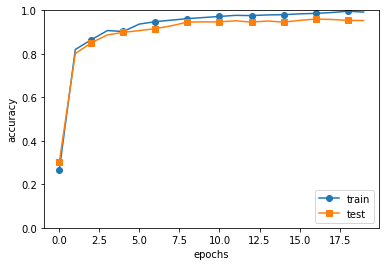

In [7]:
# %load train_convnet.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 7.6 CNN的可视化 

上例中第一层的卷积层的权重的形状是（30,1,5,5），意味着滤波器可以可视化为1通道的灰度图像。\
学习前的滤波器是随机进行初始化的，但学习后的滤波器变成了有规律的图像，比如从白到黑渐变的滤波器、含有块状区域的滤波器等。

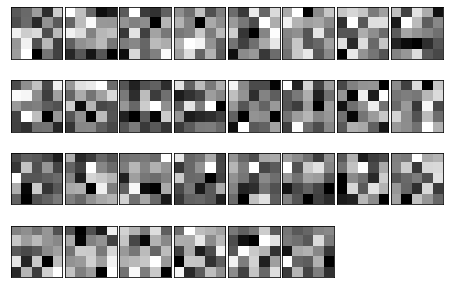

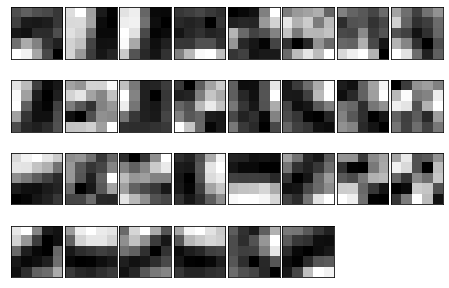

In [9]:
# %load visualize_filter.py
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 随机进行初始化后的权重
filter_show(network.params['W1'])

# 学习后的权重
network.load_params("params.pkl")
filter_show(network.params['W1'])

最开始的层对简单的边缘有响应，接下来的层对纹理有响应，再后面的层对更加复杂的物体部件有响应。

## 7.7 具有代表性的CNN 

- LeNet

LeNet有连续的卷积层和池化层（只抽选元素的子采样层）。LeNet使用sigmoid函数，而现在的CNN中主要使用ReLU函数，LeNet使用子采样（sampling）缩小中间数据的大小，而现在的CNN中Max池化是主流。

- AlexNet

AlexNet叠有多个卷积层和池化层，最后经由全输出层输出结果。与AlexNet有以下几点差异：
激活函数使用ReLU；使用局部正规化的LRN（Local Response Normalization）层
；使用Dropout

- CNN在此前的全连接层的网络中新增了卷积层和池化层
- 使用im2col函数可以简单、高效地实现卷积层和池化层
- 通过CNN的可视化，可随着层次变深，提取的信息越加高级
- LeNet和AlexNet是CNN的代表性网络
- 在深度学习的发展中，大数据和GPU做出来很大的贡献